In [9]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [10]:
!git clone https://github.com/sourjyadip/ROV_GAN

fatal: destination path 'ROV_GAN' already exists and is not an empty directory.


In [11]:
pip install -U PyYAML

Requirement already up-to-date: PyYAML in /usr/local/lib/python3.7/dist-packages (5.4.1)


In [1]:
"""
 > Training pipeline for FUnIE-GAN (paired) model
   * Paper: arxiv.org/pdf/1903.09766.pdf
 > Original Code by: https://github.com/xahidbuffon
"""
# py libs
import os
import sys
import yaml
import argparse
import numpy as np
from PIL import Image
# pytorch libs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms

import sys
sys.path.append('/content/ROV_GAN')

# local libs
from nets.commons import Weights_Normal, VGG19_PercepLoss
from nets.funiegan import GeneratorFunieGAN, DiscriminatorFunieGAN
from utils.data_utils import GetTrainingPairs, GetValImage
'''
## get configs and training options
parser = argparse.ArgumentParser()
parser.add_argument("--cfg_file", type=str, default="/content/ROV_GAN/configs/train_euvp.yaml")
#parser.add_argument("--cfg_file", type=str, default="configs/train_ufo.yaml")
parser.add_argument("--epoch", type=int, default=0, help="which epoch to start from")
parser.add_argument("--num_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=8, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0003, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of 1st order momentum")
parser.add_argument("--b2", type=float, default=0.99, help="adam: decay of 2nd order momentum")
args = parser.parse_args()
'''
## training params
epoch = 0
num_epochs = 40
batch_size =  8
lr_rate, lr_b1, lr_b2 = 0.0003, 0.5, 0.99
cfg_file =  "/content/ROV_GAN/configs/train_euvp.yaml"
# load the data config file
with open(cfg_file) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
# get info from config file
dataset_name = cfg["dataset_name"] 
dataset_path = cfg["dataset_path"]
channels = cfg["chans"]
img_width = cfg["im_width"]
img_height = cfg["im_height"] 
val_interval = cfg["val_interval"]
ckpt_interval = cfg["ckpt_interval"]


## create dir for model and validation data
samples_dir = os.path.join("samples/FunieGAN/", dataset_name)
checkpoint_dir = os.path.join("checkpoints/FunieGAN/", dataset_name)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)


""" FunieGAN specifics: loss functions and patch-size
-----------------------------------------------------"""
Adv_cGAN = torch.nn.MSELoss()
L1_G  = torch.nn.L1Loss() # similarity loss (l1)
L_vgg = VGG19_PercepLoss() # content loss (vgg)
lambda_1, lambda_con = 7, 3 # 7:3 (as in paper)
patch = (1, img_height//16, img_width//16) # 16x16 for 256x256

# Initialize generator and discriminator
generator = GeneratorFunieGAN()
discriminator = DiscriminatorFunieGAN()

# see if cuda is available
if torch.cuda.is_available():
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    Adv_cGAN.cuda()
    L1_G = L1_G.cuda()
    L_vgg = L_vgg.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    Tensor = torch.FloatTensor

# Initialize weights or load pretrained models
if epoch == 0:
    generator.apply(Weights_Normal)
    discriminator.apply(Weights_Normal)
else:
    generator.load_state_dict(torch.load("checkpoints/FunieGAN/%s/generator_%d.pth" % (dataset_name, args.epoch)))
    discriminator.load_state_dict(torch.load("checkpoints/FunieGAN/%s/discriminator_%d.pth" % (dataset_name, epoch)))
    print ("Loaded model from epoch %d" %(epoch))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate, betas=(lr_b1, lr_b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_rate, betas=(lr_b1, lr_b2))


## Data pipeline
transforms_ = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    GetTrainingPairs(dataset_path, dataset_name, transforms_=transforms_),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 8,
)

val_dataloader = DataLoader(
    GetValImage(dataset_path, dataset_name, transforms_=transforms_, sub_dir='validation'),
    batch_size=4,
    shuffle=True,
    num_workers=1,
)
img_list = []
G_losses = []
D_losses = []
iters = 0

## Training pipeline
for epoch in range(epoch, num_epochs):
    for i, batch in enumerate(dataloader):
        # Model inputs
        imgs_distorted = Variable(batch["A"].type(Tensor))
        imgs_good_gt = Variable(batch["B"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_distorted.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_distorted.size(0), *patch))), requires_grad=False)

        ## Train Discriminator
        optimizer_D.zero_grad()
        imgs_fake = generator(imgs_distorted)
        pred_real = discriminator(imgs_good_gt, imgs_distorted)
        loss_real = Adv_cGAN(pred_real, valid)
        pred_fake = discriminator(imgs_fake, imgs_distorted)
        loss_fake = Adv_cGAN(pred_fake, fake)
        # Total loss: real + fake (standard PatchGAN)
        loss_D = 0.5 * (loss_real + loss_fake) * 10.0 # 10x scaled for stability
        loss_D.backward()
        optimizer_D.step()

        ## Train Generator
        optimizer_G.zero_grad()
        imgs_fake = generator(imgs_distorted)
        pred_fake = discriminator(imgs_fake, imgs_distorted)
        loss_GAN =  Adv_cGAN(pred_fake, valid) # GAN loss
        loss_1 = L1_G(imgs_fake, imgs_good_gt) # similarity loss
        loss_con = L_vgg(imgs_fake, imgs_good_gt)# content loss
        # Total loss (Section 3.2.1 in the paper)
        loss_G = loss_GAN + lambda_1 * loss_1  + lambda_con * loss_con 
        loss_G.backward()
        optimizer_G.step()

        ## Print log
        if not i%50:
            sys.stdout.write("\r[Epoch %d/%d: batch %d/%d] [DLoss: %.3f, GLoss: %.3f, AdvLoss: %.3f]"
                              %(
                                epoch, num_epochs, i, len(dataloader),
                                loss_D.item(), loss_G.item(), loss_GAN.item(),
                               )
            )
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        ## If at sample interval save image
        batches_done = epoch * len(dataloader) + i
        if batches_done % val_interval == 0:
            imgs = next(iter(val_dataloader))
            imgs_val = Variable(imgs["val"].type(Tensor))
            imgs_gen = generator(imgs_val)
            img_sample = torch.cat((imgs_val.data, imgs_gen.data), -2)
            save_image(img_sample, "samples/FunieGAN/%s/%s.png" % (dataset_name, batches_done), nrow=5, normalize=True)

    ## Save model checkpoints
    if (epoch % ckpt_interval == 0):
        torch.save(generator.state_dict(), "checkpoints/FunieGAN/%s/generator_%d.pth" % (dataset_name, epoch))
        torch.save(discriminator.state_dict(), "checkpoints/FunieGAN/%s/discriminator_%d.pth" % (dataset_name, epoch))
    
    iters += 1




/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 39/40: batch 1400/1430] [DLoss: 0.326, GLoss: 2.828, AdvLoss: 0.906]

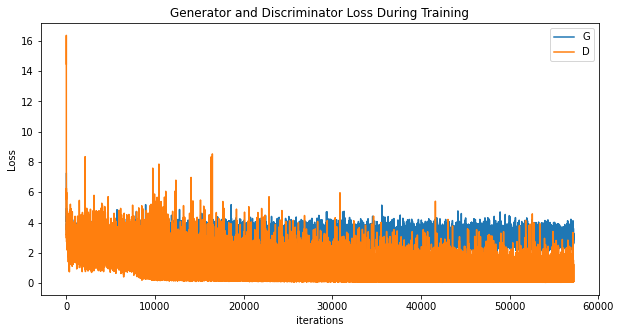

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [3]:
torch.save(generator.state_dict(), "generator.pth" )
torch.save(discriminator.state_dict(), "discriminator.pth")

In [4]:
print(G_losses)

[7.2319841384887695, 6.267151832580566, 6.589006423950195, 5.674189567565918, 5.604530334472656, 5.6000142097473145, 5.059109687805176, 4.7389020919799805, 4.32588005065918, 5.353667259216309, 5.078729629516602, 4.623598098754883, 5.704566955566406, 4.59690523147583, 4.066454887390137, 4.256100654602051, 4.893188953399658, 4.818112373352051, 3.9601197242736816, 4.0901312828063965, 4.193022727966309, 4.335812568664551, 3.504185676574707, 4.95108699798584, 4.4785261154174805, 3.844789981842041, 4.09887170791626, 3.9401021003723145, 3.567415714263916, 3.9642813205718994, 3.711353063583374, 3.387207269668579, 3.7477922439575195, 4.075026512145996, 4.055822372436523, 3.396284580230713, 4.144636631011963, 3.1485607624053955, 3.6208736896514893, 4.014390468597412, 4.157716751098633, 4.351258754730225, 4.170113563537598, 3.45180082321167, 4.449965000152588, 3.5034780502319336, 3.2882282733917236, 3.2289113998413086, 3.378093719482422, 4.0896759033203125, 3.7051665782928467, 3.5201430320739746,

In [5]:
print(D_losses)

[14.481306076049805, 16.371326446533203, 9.778669357299805, 6.223229885101318, 5.518550395965576, 5.645174026489258, 7.3467864990234375, 6.268243789672852, 4.291685104370117, 3.9653637409210205, 4.084580421447754, 3.6623551845550537, 3.769069194793701, 3.4090166091918945, 3.3629047870635986, 3.330990791320801, 3.3468806743621826, 3.240232467651367, 3.2107086181640625, 2.9716336727142334, 3.362309694290161, 3.23089599609375, 3.2532339096069336, 3.1887383460998535, 3.283292293548584, 4.178650856018066, 4.590859413146973, 5.999330520629883, 3.8898088932037354, 3.3504579067230225, 3.349086046218872, 3.1874239444732666, 3.0215587615966797, 3.0853395462036133, 2.995035171508789, 2.717083692550659, 2.819007635116577, 3.1133599281311035, 3.8484230041503906, 3.70709228515625, 3.1132097244262695, 3.292705535888672, 3.229395866394043, 3.825058937072754, 2.807840347290039, 2.9754204750061035, 2.752523899078369, 2.8443241119384766, 2.8331589698791504, 2.777710437774658, 2.7682077884674072, 2.684946

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


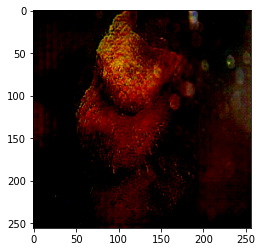

In [23]:
from IPython.display import Image
import PIL
#from google.colab.patches import cv2_imshow
img = PIL.Image.open(r"/content/wreck.jpg")
 
 
# height, width, number of channels in image
img_height = 256
img_width = 256
dim = (img_width, img_height)

img = img.resize(dim)

loader = transforms.Compose([transforms.Resize((img_height, img_width), PIL.Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = image_name
    image = loader(image)
    imgs_val = Variable(image.type(Tensor))
    #imgs_gen = generator(imgs_val)
    #return image.cuda()  #assumes that you're using GPU
    return imgs_val

imgs_val = image_loader(img)

imgs_gen = generator(imgs_val[None, ...])
imgs_gen  = Tensor.cpu(imgs_gen)
imgs_gen = imgs_gen.squeeze().permute(1,2,0)
imgs_gen = imgs_gen.detach().numpy()

plt.imshow(imgs_gen)
plt.show()